# Imports 

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
np.random.seed(0)

## Utility Functions

In [67]:
def plot_feature_distributions(data:pd.DataFrame , feature_names:list) -> None:
    """
    Plots Feature distributions
    @param data - pandas data frame of data
    @param feature_names - names of features to plot
    """
    num_features = len(feature_names)
    num_rows = num_features // 2 + num_features % 2  

    plt.figure(figsize=(12, 4 * num_rows))  

    for i, feature in enumerate(feature_names):
        plt.subplot(num_rows, 2, i + 1)   
        sns.histplot(data[feature], kde=True)
        plt.title(feature)

    plt.tight_layout()
    plt.show()

def get_most_corr_xcols(correlation_matrix: pd.DataFrame, top_n:int=10) -> pd.DataFrame:
    """
    Grabs the most correlated x features 
    @param correlation_matrixL - correlation matrix pandas data frame 
    @param top_n - number of top correlations to print 
    @returns top_correlations_df
    """
    # Converts the matrix to a Series with multi-level index for easier sorting.
    correlation_pairs = correlation_matrix.unstack()
    
    # Remove self correlations (correlation of each variable with itself)
    correlation_pairs = correlation_pairs[correlation_pairs.index.get_level_values(0) != correlation_pairs.index.get_level_values(1)]
    
    # Sort the correlations by absolute value in descending order
    sorted_correlation_pairs = correlation_pairs.abs().sort_values(ascending=False)
    
    # Get the top N correlations
    top_correlations = sorted_correlation_pairs.head(top_n)
    
    # Print the top correlations with their original values
    for index in top_correlations.index:
        var1, var2 = index
        corr_value = correlation_matrix.loc[var1, var2]
        print(f"{var1:40} and {var2:40}: {corr_value:.2f}")
    top_correlations_df = pd.DataFrame({
        'Variable 1': [index[0] for index in top_correlations.index],
        'Variable 2': [index[1] for index in top_correlations.index],
        'Correlation': [correlation_matrix.loc[index[0], index[1]] for index in top_correlations.index]
    })
    return top_correlations_df
    
def get_top_xcors_withy(correlation_matrix :pd.DataFrame, target_column: str, top_n=4)-> pd.DataFrame:
    """
    Grabs the most correlated x features with given y column 
    @param correlation_matrixL - correlation matrix pandas data frame
    @param target_column - y column name 
    @param top_n - number of top correlations to print 
    @returns top_correlations_df
    """
    # most correlated x columns with the y column 
    target_correlations = correlation_matrix[target_column]
    
    # Remove the target column's self-correlation
    target_correlations = target_correlations.drop(target_column)
    
    # Sort the correlations by absolute value in descending order
    sorted_target_correlations = target_correlations.abs().sort_values(ascending=False)
    
    top_correlations = sorted_target_correlations.head(top_n)
    
    # Print the top correlations with their original values
    for index in top_correlations.index:
        corr_value = correlation_matrix.loc[index, target_column]
        print(f"{index:55} and {target_column:15}: {corr_value:.2f}")

    top_correlations_df = pd.DataFrame({
        'Variable': top_correlations.index,
        'Correlation with Target': [correlation_matrix.loc[index, target_column] for index in top_correlations.index]
    })
    return top_correlations_df

# Data Load

In [11]:
data = pd.read_csv("fetal_health.csv")
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


# Data Analysis 

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [20]:
# NA check 
data.isna().sum()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

In [16]:
data.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,...,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,...,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,...,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,...,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


In [17]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


<Axes: xlabel='fetal_health', ylabel='count'>

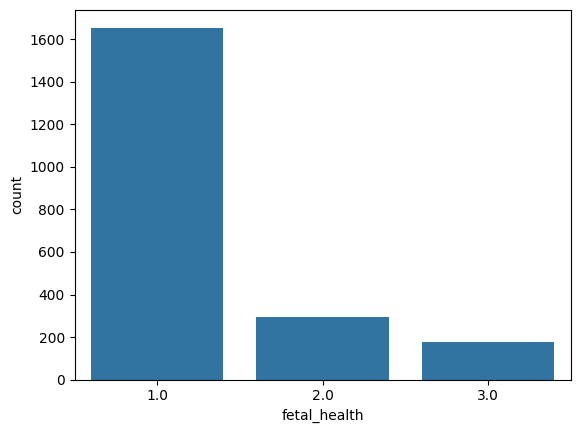

In [21]:
sns.countplot(data= data, x="fetal_health")

In [38]:
y_counts = data['fetal_health'].value_counts()
print(y_counts)

sum = y_counts.sum()
perecentages = (y_counts/sum)*100
print(perecentages)

fetal_health
1.0    1655
2.0     295
3.0     176
Name: count, dtype: int64
fetal_health
1.0    77.845720
2.0    13.875823
3.0     8.278457
Name: count, dtype: float64


<Axes: >

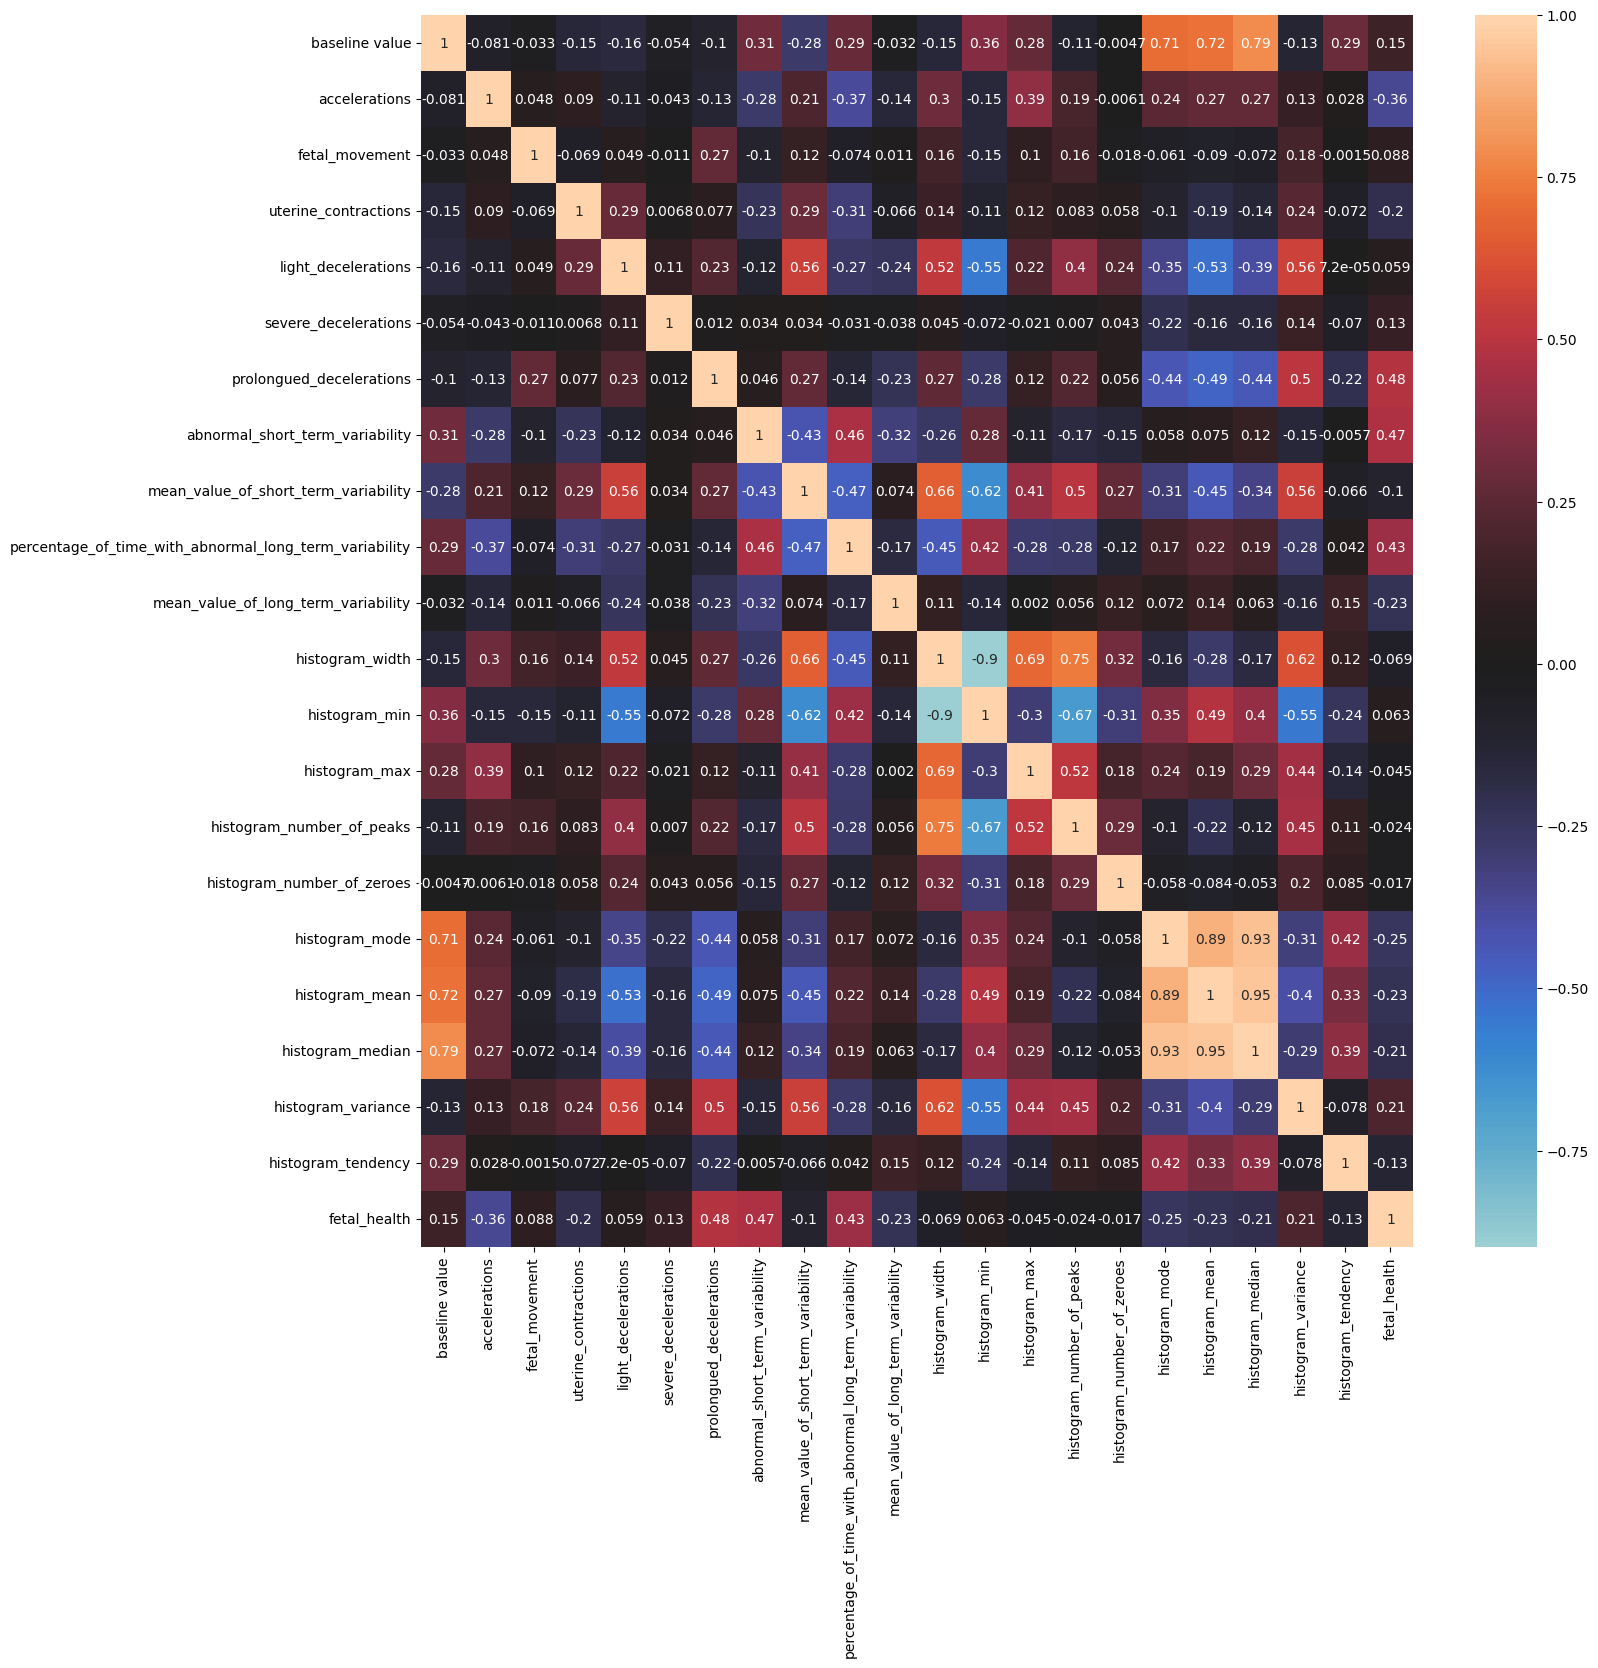

In [45]:
#correlation matrix
corrmat= data.corr()
plt.figure(figsize=(16,16))  
sns.heatmap(corrmat, annot=True, center=0)

In [65]:
get_most_corr_xcols(corrmat)

histogram_median                         and histogram_mean                          : 0.95
histogram_mean                           and histogram_median                        : 0.95
histogram_mode                           and histogram_median                        : 0.93
histogram_median                         and histogram_mode                          : 0.93
histogram_min                            and histogram_width                         : -0.90
histogram_width                          and histogram_min                           : -0.90
histogram_mean                           and histogram_mode                          : 0.89
histogram_mode                           and histogram_mean                          : 0.89
baseline value                           and histogram_median                        : 0.79
histogram_median                         and baseline value                          : 0.79


,Variable 1,Variable 2,Correlation
0,histogram_median,histogram_mean,0.948251
1,histogram_mean,histogram_median,0.948251
2,histogram_mode,histogram_median,0.933399
3,histogram_median,histogram_mode,0.933399
4,histogram_min,histogram_width,-0.898519
5,histogram_width,histogram_min,-0.898519
6,histogram_mean,histogram_mode,0.893412
7,histogram_mode,histogram_mean,0.893412
8,baseline value,histogram_median,0.789246
9,histogram_median,baseline value,0.789246


In [68]:
target_column = 'fetal_health'
correlations = get_top_xcors_withy(corrmat, target_column)

prolongued_decelerations                                and fetal_health   : 0.48
abnormal_short_term_variability                         and fetal_health   : 0.47
percentage_of_time_with_abnormal_long_term_variability  and fetal_health   : 0.43
accelerations                                           and fetal_health   : -0.36


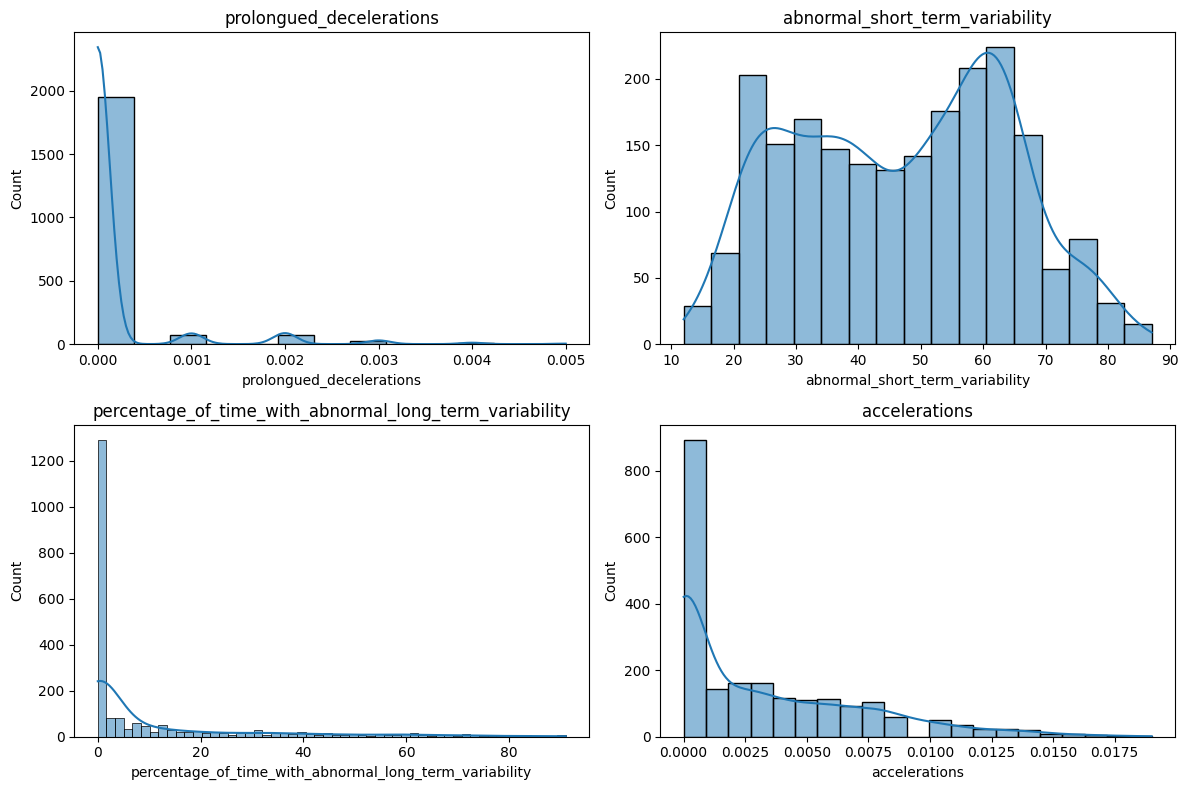

In [77]:
# Create distribution plots. 
x_feats = correlations['Variable']
most_correlated_x_features = x_feats.values.tolist()
plot_feature_distributions(data, most_correlated_x_features)

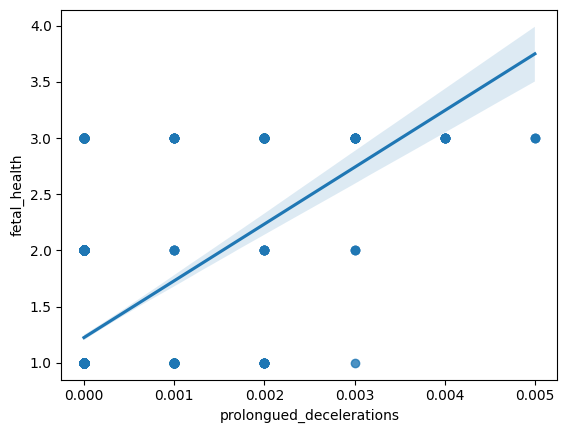

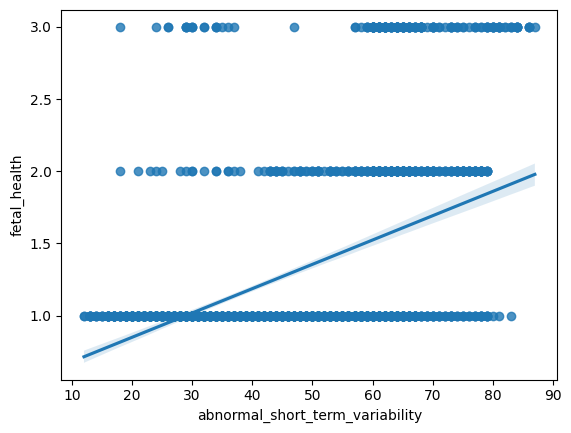

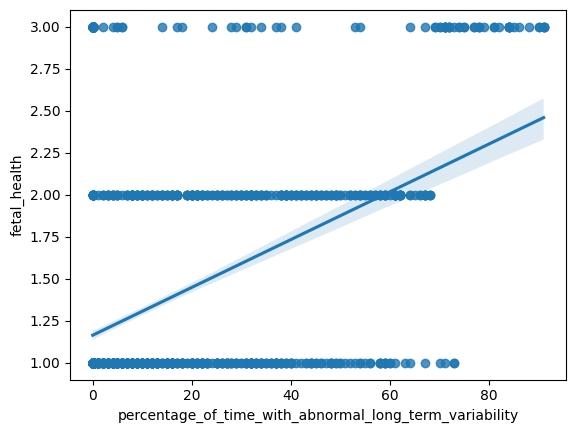

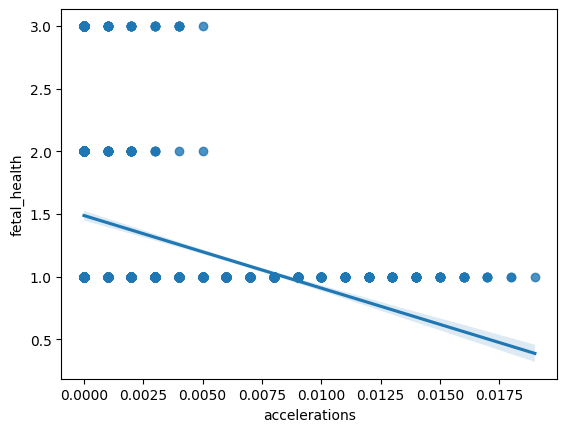

In [80]:
for x_feat in most_correlated_x_features:
    sns.regplot(x=x_feat, y=target_column, data=data, scatter=True)
    plt.show()

In [96]:
data_columns = data.columns.drop('fetal_health').values.tolist()

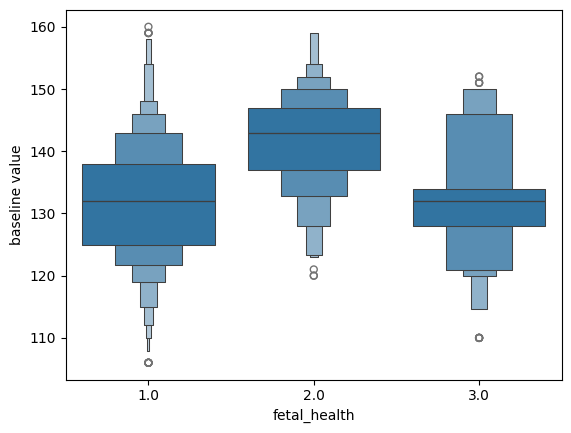

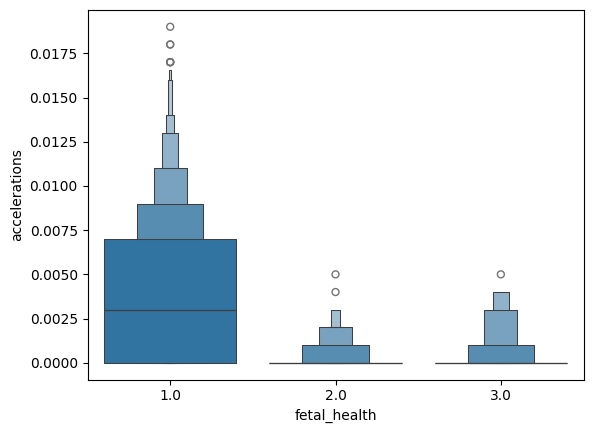

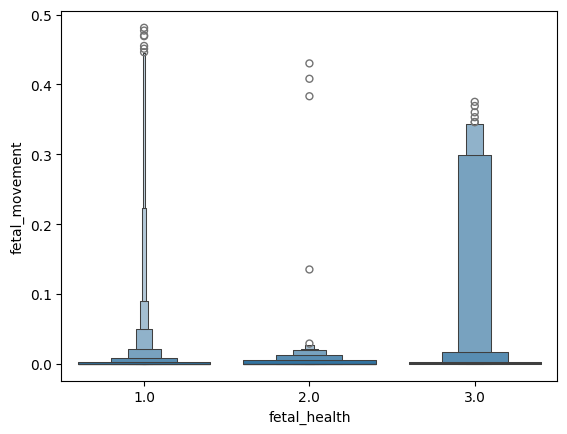

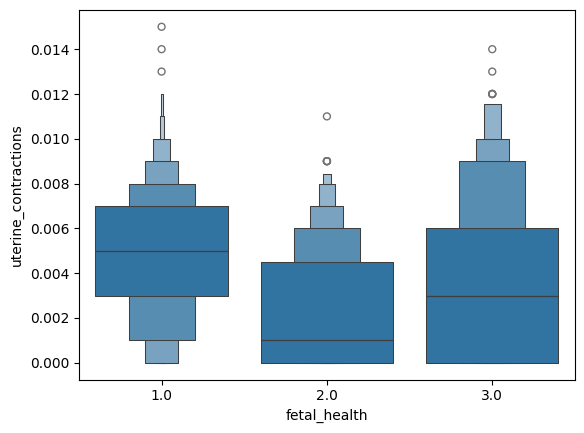

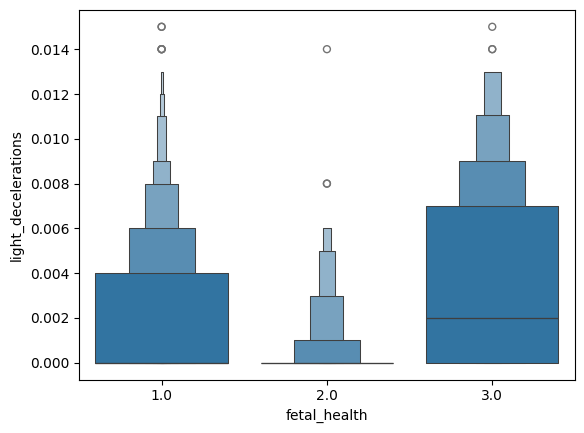

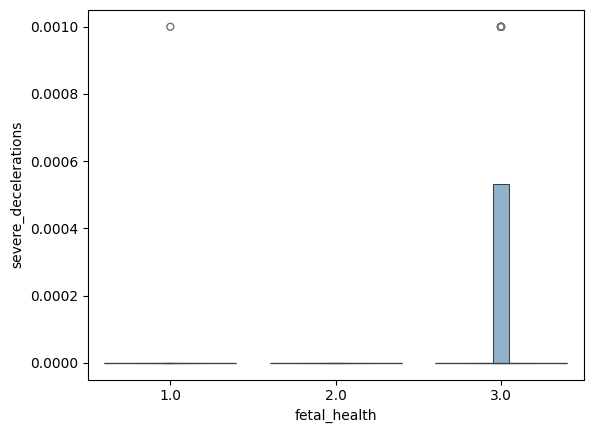

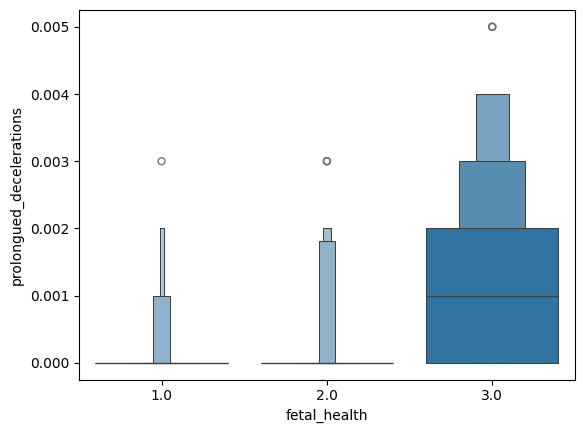

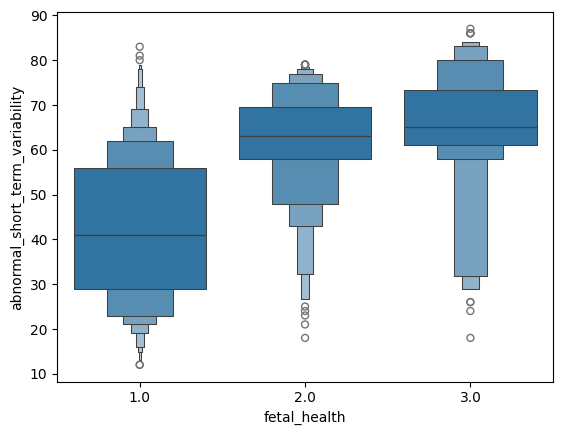

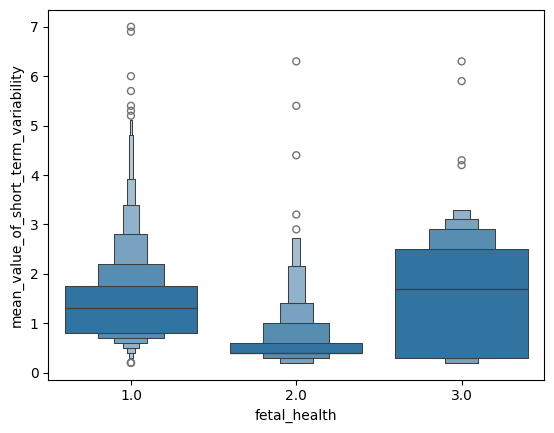

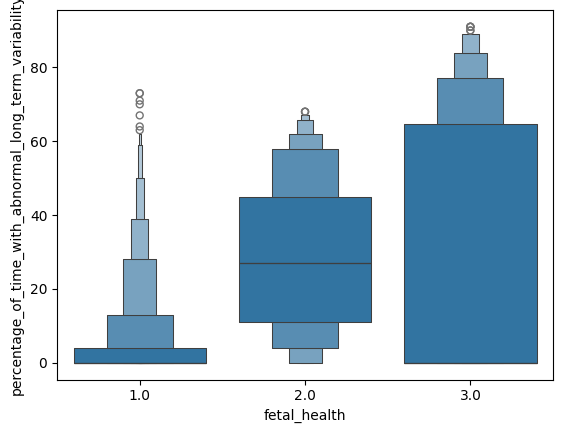

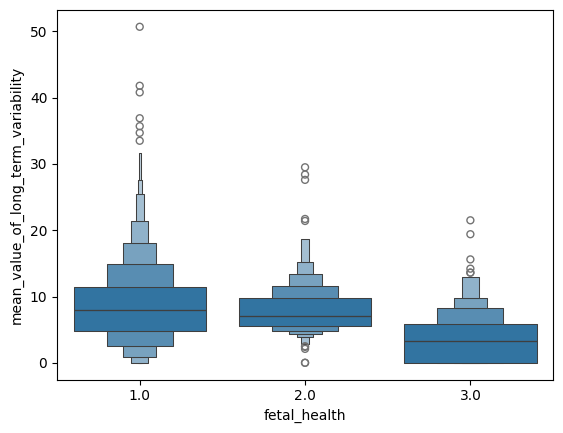

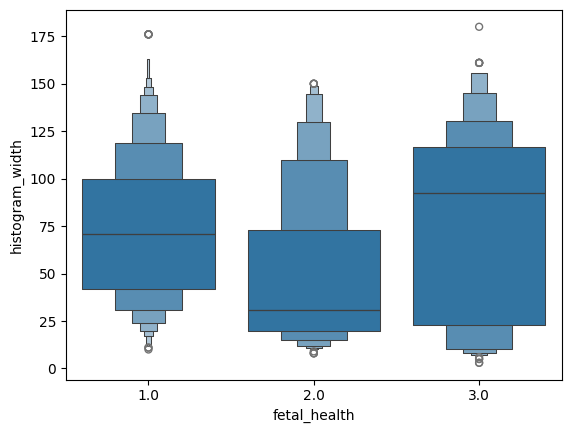

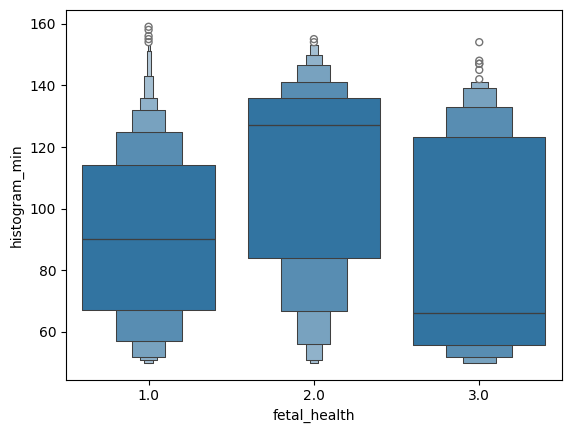

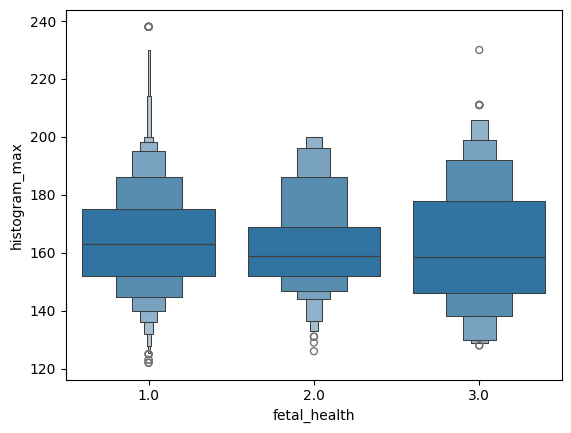

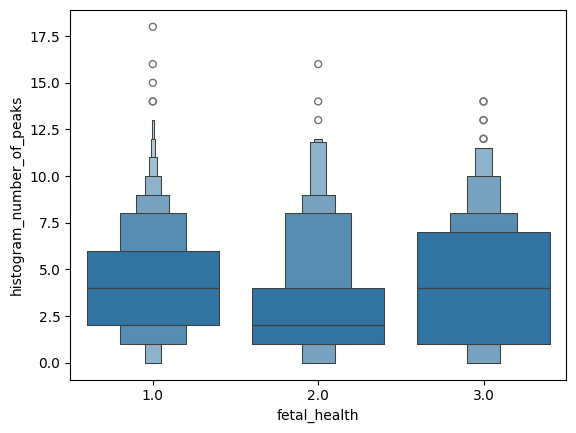

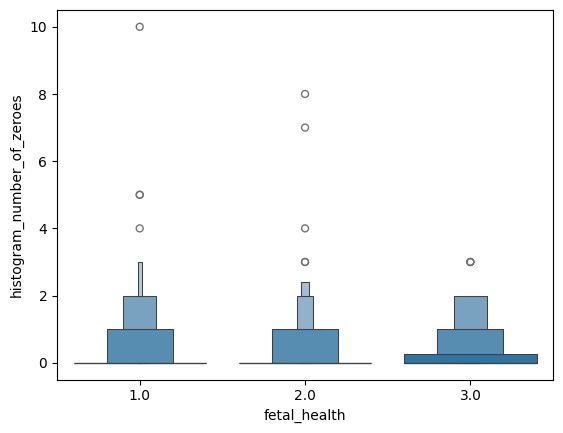

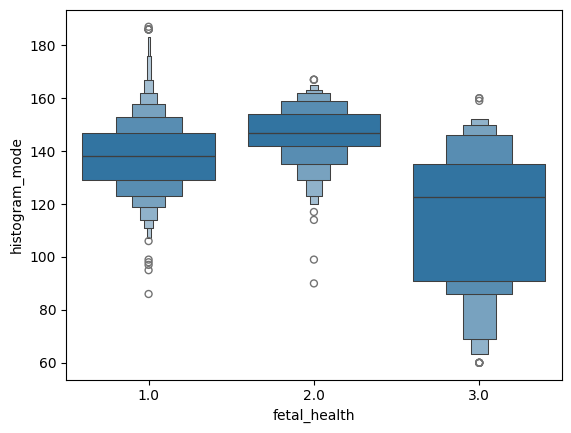

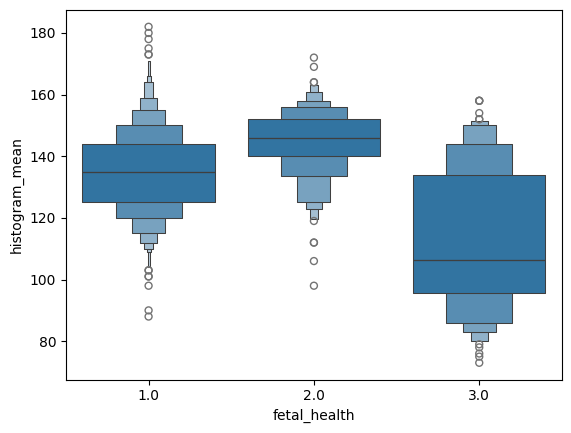

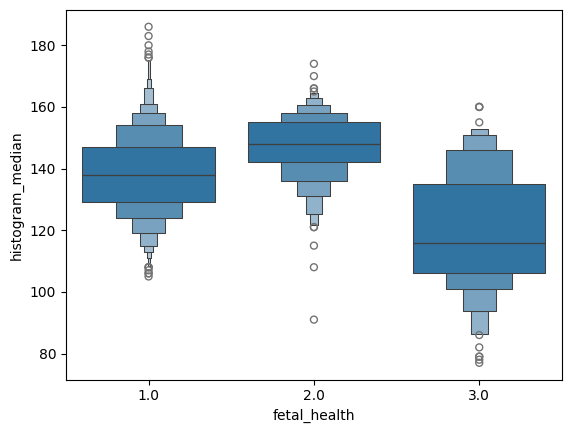

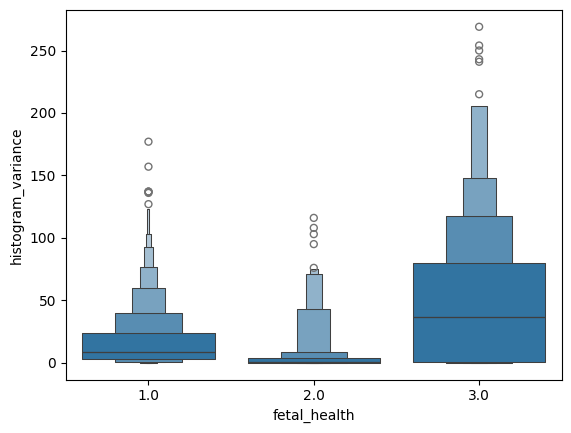

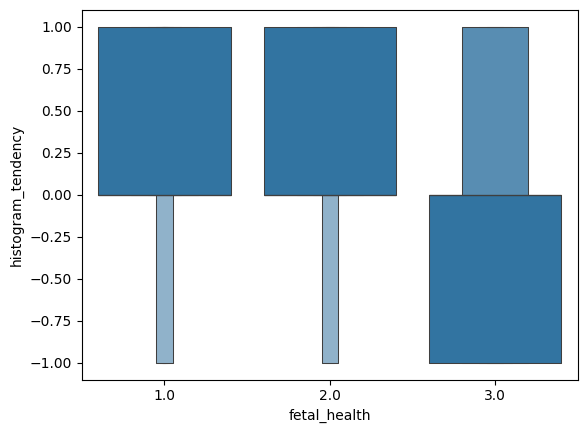

In [97]:
# The boxenplot shows the distribution and summary statistics.
# The swarmplot overlays the individual data points, providing a clear view of the data density and distribution.
for col in data_columns:
    # sns.swarmplot(x=data["fetal_health"], y=data[col], color="black", alpha=0.5 )
    sns.boxenplot(x=data[target_column], y=data[col])
    plt.show()

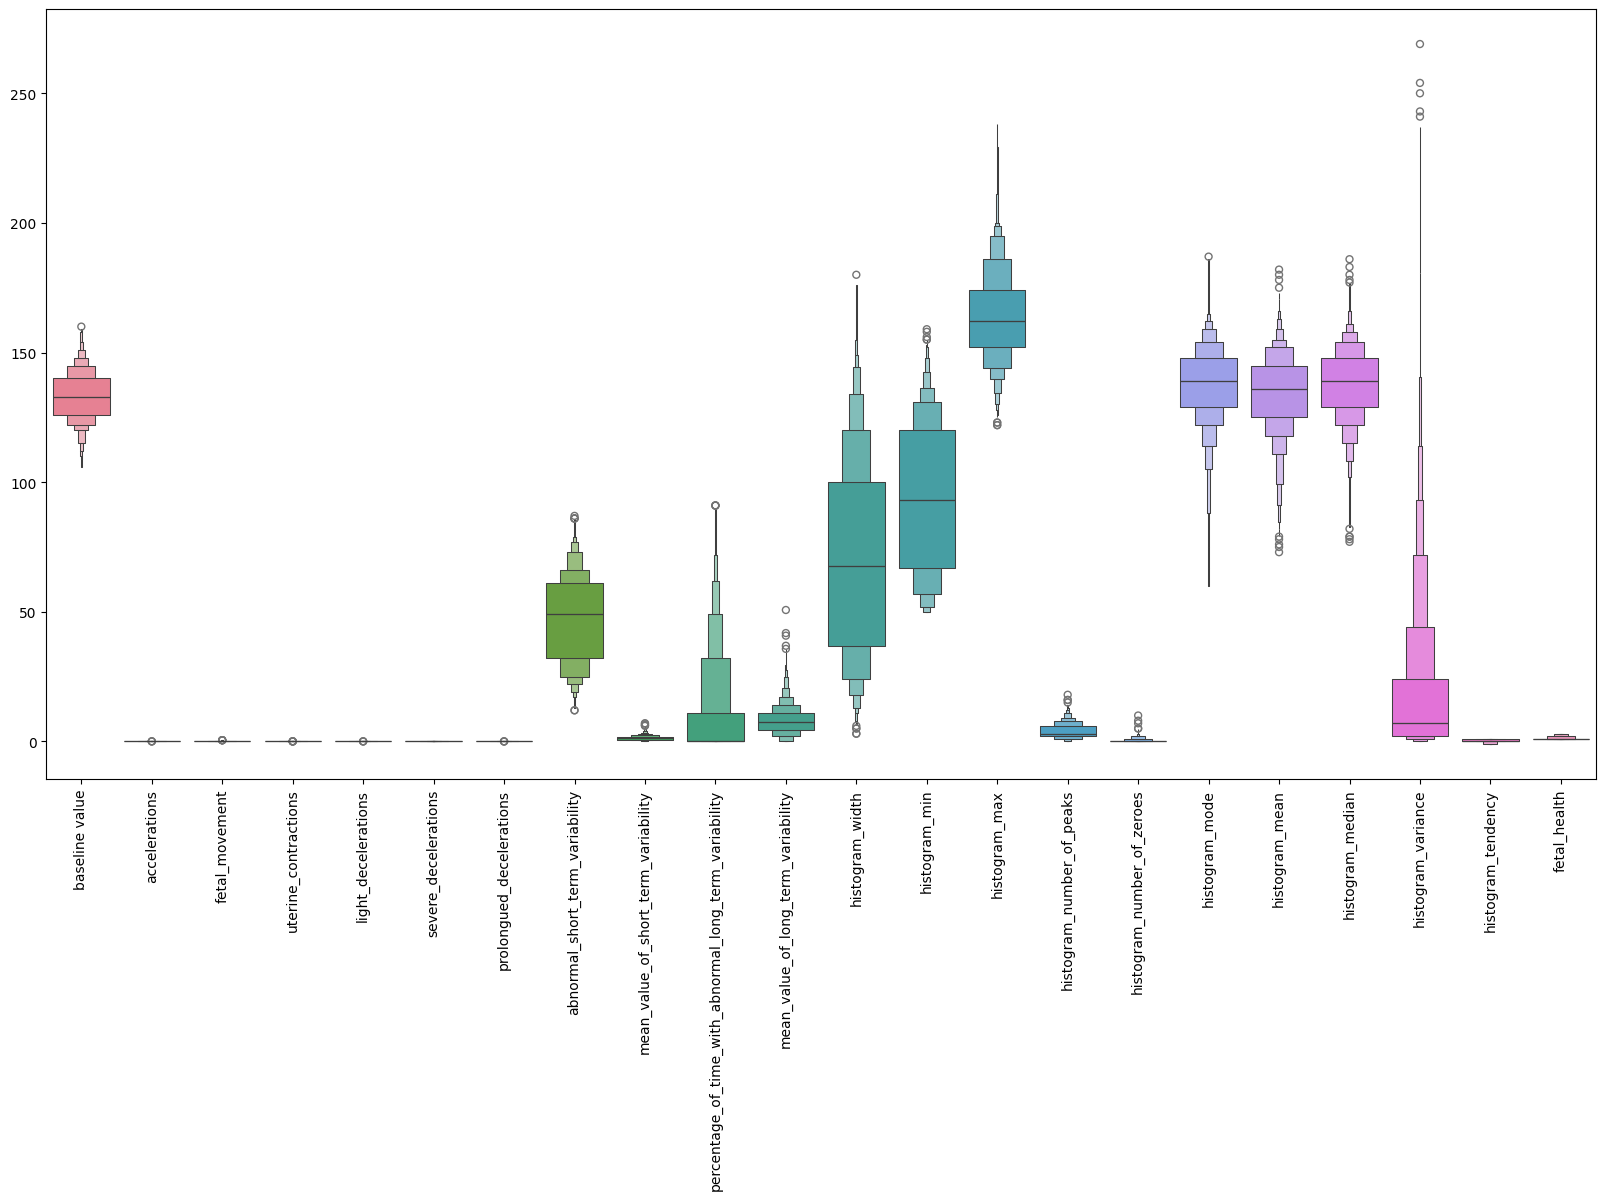

In [111]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = data)
plt.xticks(rotation=90)
plt.show()

# Model Exploration

In [108]:
x = data.drop(['fetal_health'], axis=1)
y = data["fetal_health"]

In [112]:
col_names = list(x.columns)
s_scaler = preprocessing.StandardScaler()
x_df= s_scaler.fit_transform(x)
x_df = pd.DataFrame(x_df, columns=col_names)   
x_df.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,1.069490e-15,1.000235,-2.775197,-0.742373,-0.030884,0.680604,2.713428
accelerations,2126.0,-4.010589e-17,1.000235,-0.822388,-0.822388,-0.304881,0.730133,4.093929
fetal_movement,2126.0,-1.336863e-17,1.000235,-0.203210,-0.203210,-0.203210,-0.138908,10.106540
uterine_contractions,2126.0,-1.336863e-16,1.000235,-1.482465,-0.803434,-0.124404,0.894142,3.610264
light_decelerations,2126.0,-5.347452e-17,1.000235,-0.638438,-0.638438,-0.638438,0.375243,4.429965
severe_decelerations,2126.0,6.684315e-18,1.000235,-0.057476,-0.057476,-0.057476,-0.057476,17.398686
prolongued_decelerations,2126.0,1.336863e-17,1.000235,-0.268754,-0.268754,-0.268754,-0.268754,8.208570
abnormal_short_term_variability,2126.0,-7.352747e-17,1.000235,-2.035639,-0.872088,0.116930,0.815060,2.327675
mean_value_of_short_term_variability,2126.0,6.684315e-17,1.000235,-1.282833,-0.716603,-0.150373,0.415857,6.417893
percentage_of_time_with_abnormal_long_term_variability,2126.0,-5.347452e-17,1.000235,-0.535361,-0.535361,-0.535361,0.062707,4.412293


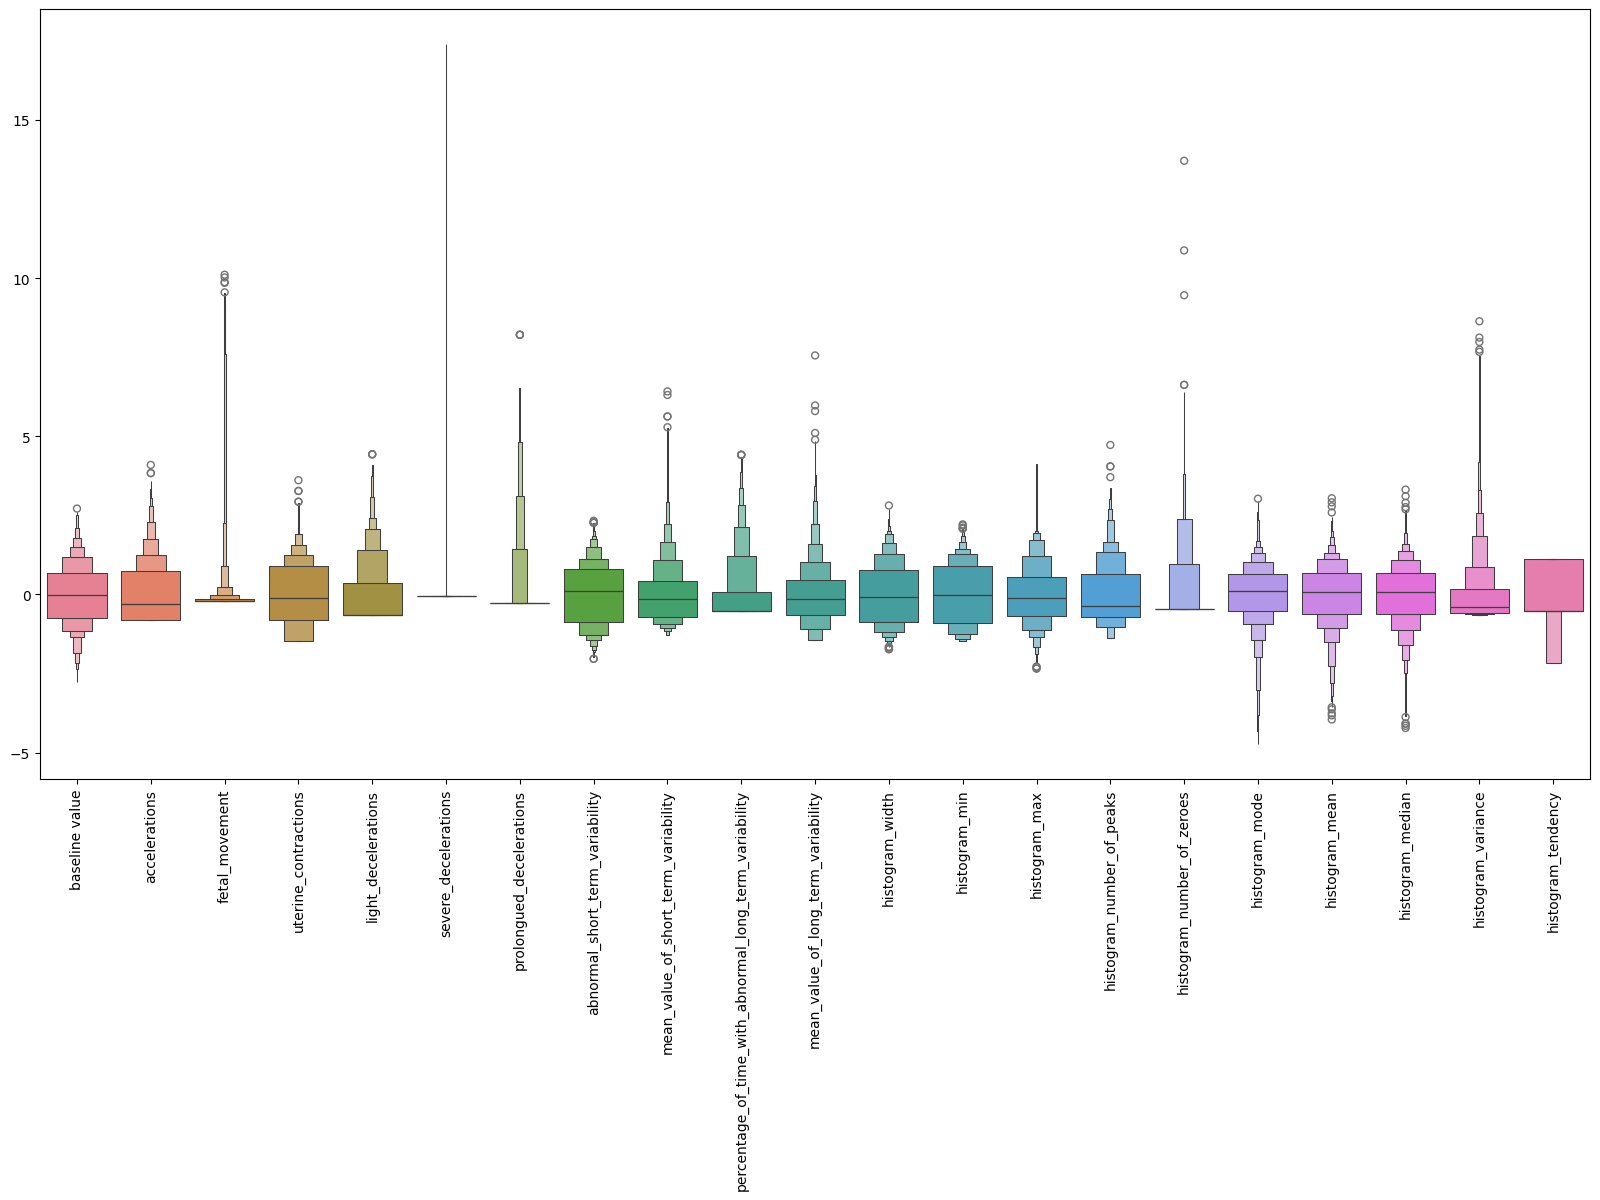

In [113]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = x_df)
plt.xticks(rotation=90)
plt.show()

In [117]:
# build test and train 
X_train, X_test, y_train,y_test = train_test_split(x_df,y,test_size=0.25, random_state=7|2)


In [121]:
pipeline_lr=Pipeline([('lr_classifier',LogisticRegression(random_state=72))])

pipeline_knn=Pipeline([('knn_classifier',KNeighborsClassifier())])

pipeline_dt=Pipeline([ ('dt_classifier',DecisionTreeClassifier(random_state=72))])

pipeline_rf=Pipeline([('rf_classifier',RandomForestClassifier(random_state=72))])

pipeline_svc=Pipeline([('sv_classifier',SVC(random_state=72))])

# List of all the pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_svc, pipeline_knn]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest', 3: "SVC", 4: "KNN"}


# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)

#cross validation on accuracy 
cv_results_accuracy = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train, y_train, cv=10 )
    cv_results_accuracy.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))



Logistic Regression: 0.894568 
Decision Tree: 0.922186 
RandomForest: 0.944131 
SVC: 0.913396 
KNN: 0.905228 


In [123]:
pred_rfc = pipeline_rf.predict(X_test)
accuracy = accuracy_score(y_test, pred_rfc)
print(accuracy)

0.9473684210526315


In [124]:
parameters = { 
    'n_estimators': [100,150, 200,500,700,900],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,6,8,12,14,16],
    'criterion' :['gini', 'entropy'],
    'n_jobs':[-1,1,None]
}
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters, cv= 5)
CV_rfc.fit(X_train, y_train)


#Getting the outcome of gridsearch
CV_rfc.best_params_

C:\Users\clars\anaconda3\envs\machinelearning\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1080 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\clars\anaconda3\envs\machinelearning\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\clars\anaconda3\envs\machinelearning\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\clars\anaconda3\envs\machinelearning\lib\site-packages\sklearn\base.py", line 666, in _validate_para

{'criterion': 'entropy',
 'max_depth': 14,
 'max_features': 'log2',
 'n_estimators': 100,
 'n_jobs': -1}

In [125]:
RF_model = RandomForestClassifier(**CV_rfc.best_params_)
RF_model.fit(X_train, y_train)
#Testing the Model on test set
predictions=RF_model.predict(X_test)
acccuracy= accuracy_score(y_test,predictions)
acccuracy

0.9473684210526315

In [126]:
acccuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions, average="weighted")
precision = precision_score(y_test, predictions, average="weighted")
f1_score = f1_score(y_test, predictions, average="micro")

print("********* Random Forest Results *********")
print("Accuracy    : ", acccuracy)
print("Recall      : ", recall)
print("Precision   : ", precision)
print("F1 Score    : ", f1_score)

********* Random Forest Results *********
Accuracy    :  0.9473684210526315
Recall      :  0.9473684210526315
Precision   :  0.9464899766328392
F1 Score    :  0.9473684210526315


In [127]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.96      0.98      0.97       406
         2.0       0.85      0.79      0.82        71
         3.0       0.98      0.91      0.94        55

    accuracy                           0.95       532
   macro avg       0.93      0.89      0.91       532
weighted avg       0.95      0.95      0.95       532



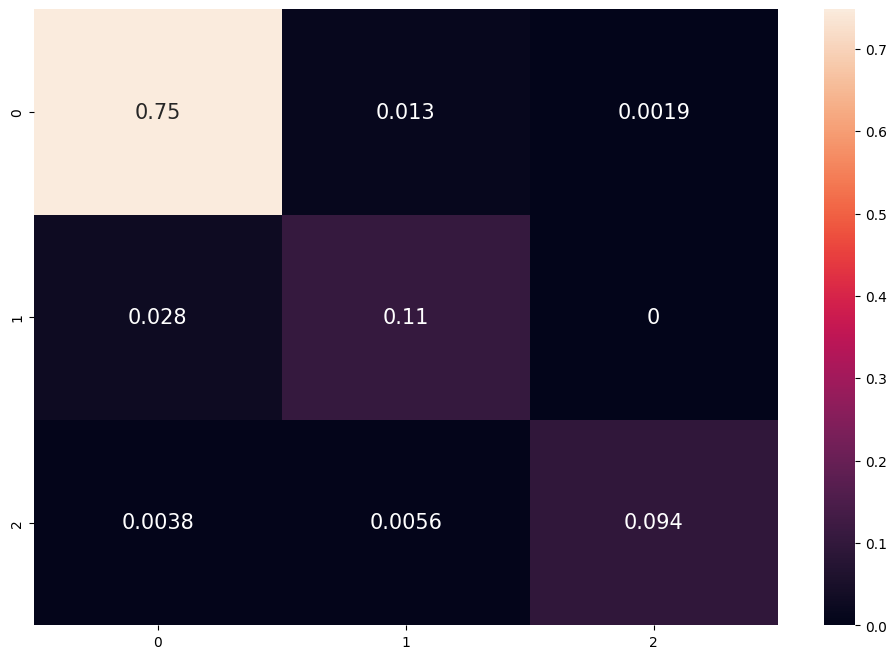

In [131]:
# cofusion matrix
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix/np.sum(cf_matrix),annot = True, annot_kws = {'size':15})
plt.show()